In [1]:
%matplotlib qt

In [2]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [3]:
# Use the .fif files produced from kit2fiff packages
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)

# new = new gel ; original: old gel

EEG_cntFile = root_data_path / Path('eeg_20250610_test_new_MMN_Notched.cnt') #eeg_20250610_test_original_noNotch.cnt
#LDT_raw =  mne.io.read_raw_kit(LDT_confile, stim = [195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進
#LDT_raw.plot()
#events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

MMN_raw = mne.io.read_raw_cnt(EEG_cntFile, eog="header", preload=True)
#MMN_raw.plot()

n_MMN_raw = MMN_raw.copy()
#n_MMN_filtered = n_MMN_raw.notch_filter(freqs=50, picks="all")
n_MMN_raw.plot()
#n_MMN_filtered.plot()
print(n_MMN_raw.info)

# Calculate the power spectrum density to examine the power in each frequency.
n_MMN_raw.compute_psd(fmin=1, fmax=100).plot()#.(fmax=100)

# Save the cnt into .fif for a easier further analysis
fif_DIR = root_data_path / 'rawfif_all'
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
fif_DIR.mkdir(exist_ok=True)

#n_MMN_raw.save(uncut_fif_DIR / Path('eeg_20250610_test_new_MMN_Notched.fif'), overwrite=True)

/Users/neuroling/Downloads/20250610_EEG-Demo
Reading 0 ... 415231  =      0.000 ...   405.499 secs...
Using qt as 2D backend.
Using pyopengl with version 3.1.1a1
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 1 EOG, 1 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 07:03:10 UTC
 nchan: 2
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 5 items (dict)
>
Effective window size : 2.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Channels marked as bad:
['Trigger']


In [53]:
n_MMN_raw.ch_names # Where are the annotations

['Fz_1', 'Trigger']

In [84]:
# This is the original brain data's triggers
'''
Triggers_ID:
12345 >> the start of task
55 >> the end of task
20 ~ 24 >> the start of questions' texts (irrelevant in here, please ignore it)
'''

## Segment the EEG according to tasks, 5 parts in total.
events_ann_ndArray = mne.events_from_annotations(n_MMN_raw)[0]
print(events_ann_ndArray)
print(type(events_ann_ndArray))
print(len(events_ann_ndArray))
print(mne.events_from_annotations(n_MMN_raw)[1], len(mne.events_from_annotations(n_MMN_raw)[1]))

events_id_DICT = {'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11}
raw_sfreq = n_MMN_raw.info['sfreq'] # supposedly to be 1000 Hz
fifname_LIST = ["eyeOpen_2min", "eyeClose_2min", "Blink_60count", "HEOG_60count", "VEOG_60count"]

# Get the start points in every 3 segment, staring from index[0]
start_tNDarray = events_ann_ndArray[::3]
print(start_tNDarray)
print(len(start_tNDarray))

# Get the end points in every 3 segment, staring from index[2]
end_tNDarray = events_ann_ndArray[2::3]
print(end_tNDarray)
print(len(end_tNDarray))

# segment the EEG data according to the points that are going to be converted into times, and save the raw EEG files
for i in range(5):
    print(start_tNDarray[i][0]/int(raw_sfreq), end_tNDarray[i][0]/int(raw_sfreq))
    # in here, we exclude the +0.5 at the end of the end points for the reason of 0.5 delay when the questions start trigger appear
    cut_eeg = n_MMN_raw.copy().crop((start_tNDarray[i][0]/int(raw_sfreq)), (end_tNDarray[i][0]/int(raw_sfreq)))
    cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


"""
epochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)
                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)
"""

Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
[[  8744      0      1]
 [ 68651      0      3]
 [144131      0     11]
 [146165      0      2]
 [209144      0      4]
 [278897      0     11]
 [280916      0      8]
 [346966      0      5]
 [357762      0     11]
 [359970      0      9]
 [432166      0      6]
 [439272      0     11]
 [441476      0     10]
 [510597      0      7]
 [520315      0     11]]
<class 'numpy.ndarray'>
15
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
{'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11} 11
[[  8744      0      1]
 [146165      0      2]
 [280916      0      8]
 [359970      0      9]
 [441476      0     10]]
5
[[144131      0     11]
 [278897      0     11]
 [357762      0     11]
 [439272      0     11]
 [520315      

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeOpen_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeClose_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_L

Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/HEOG_60count_new_Notched.fif
[done]
431.12890625 508.1201171875
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
[done]


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


'\nepochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)\n                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)\n'

Effective window size : 2.000 (s)


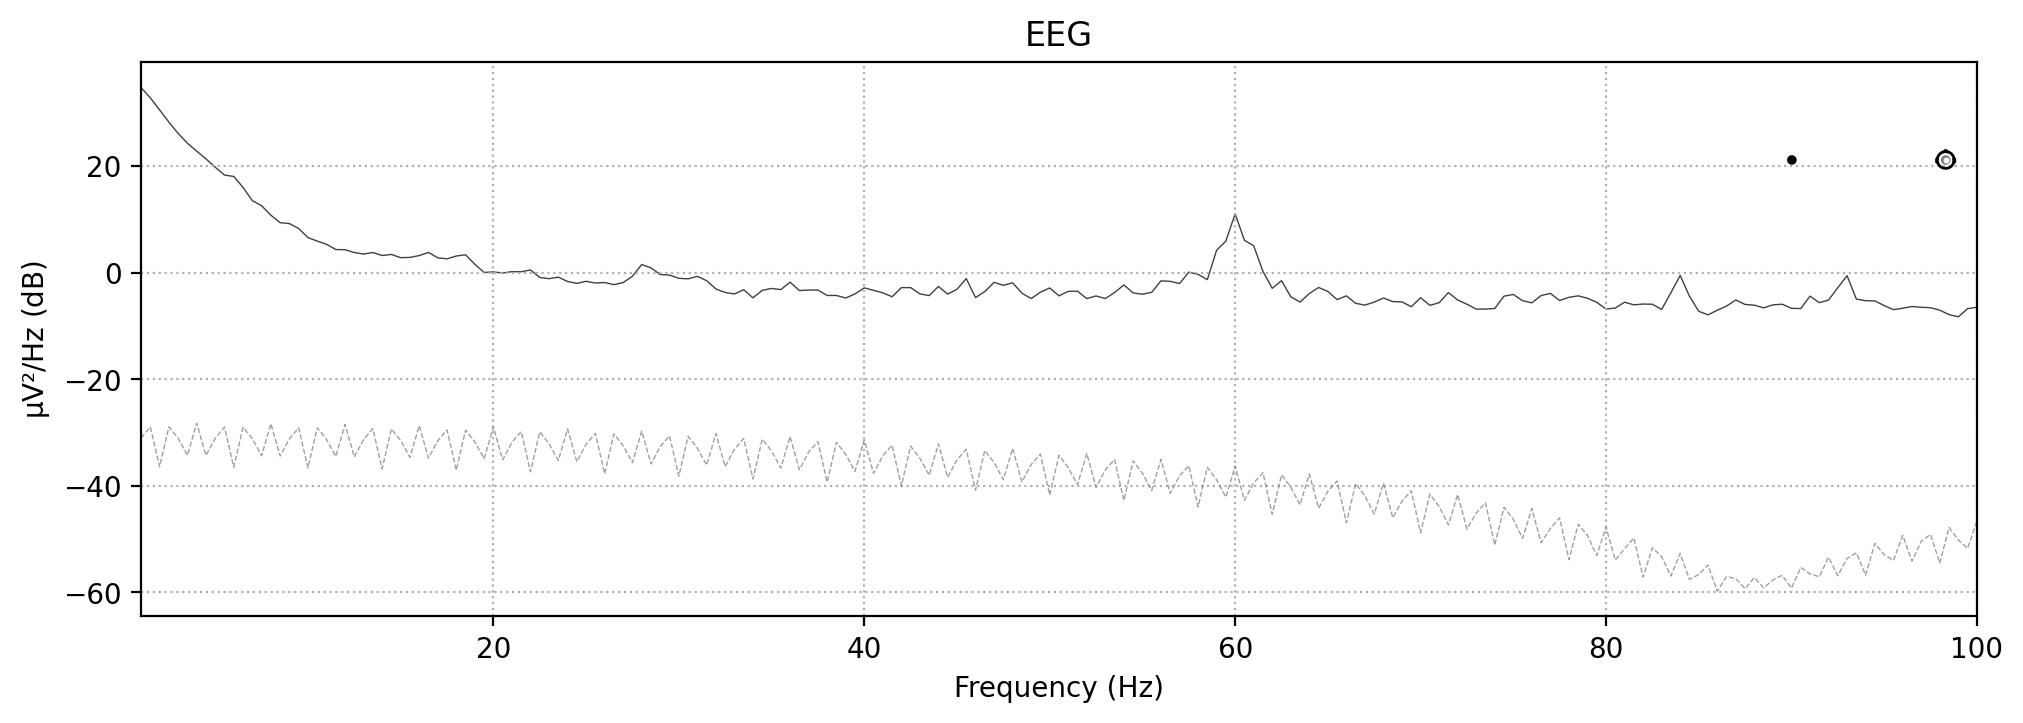

2025-08-22 18:03:51.157 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:55.698 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:57.323 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:57.590 python[16801:20845248] +[CATransaction synchronize] called within transaction


In [47]:
raw_MMN_fif.compute_psd(fmin=1, fmax=100).plot()


Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_noNotch.fif...
    Range : 0 ... 407295 =      0.000 ...   397.749 secs
Ready.
Reading 0 ... 407295  =      0.000 ...   397.749 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_Notched.fif...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/1827231909.py:5: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  noNotch_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/1827231909.py:15: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif

    Range : 0 ... 410623 =      0.000 ...   400.999 secs
Ready.
Reading 0 ... 410623  =      0.000 ...   400.999 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Effective window size : 2.000 (s)


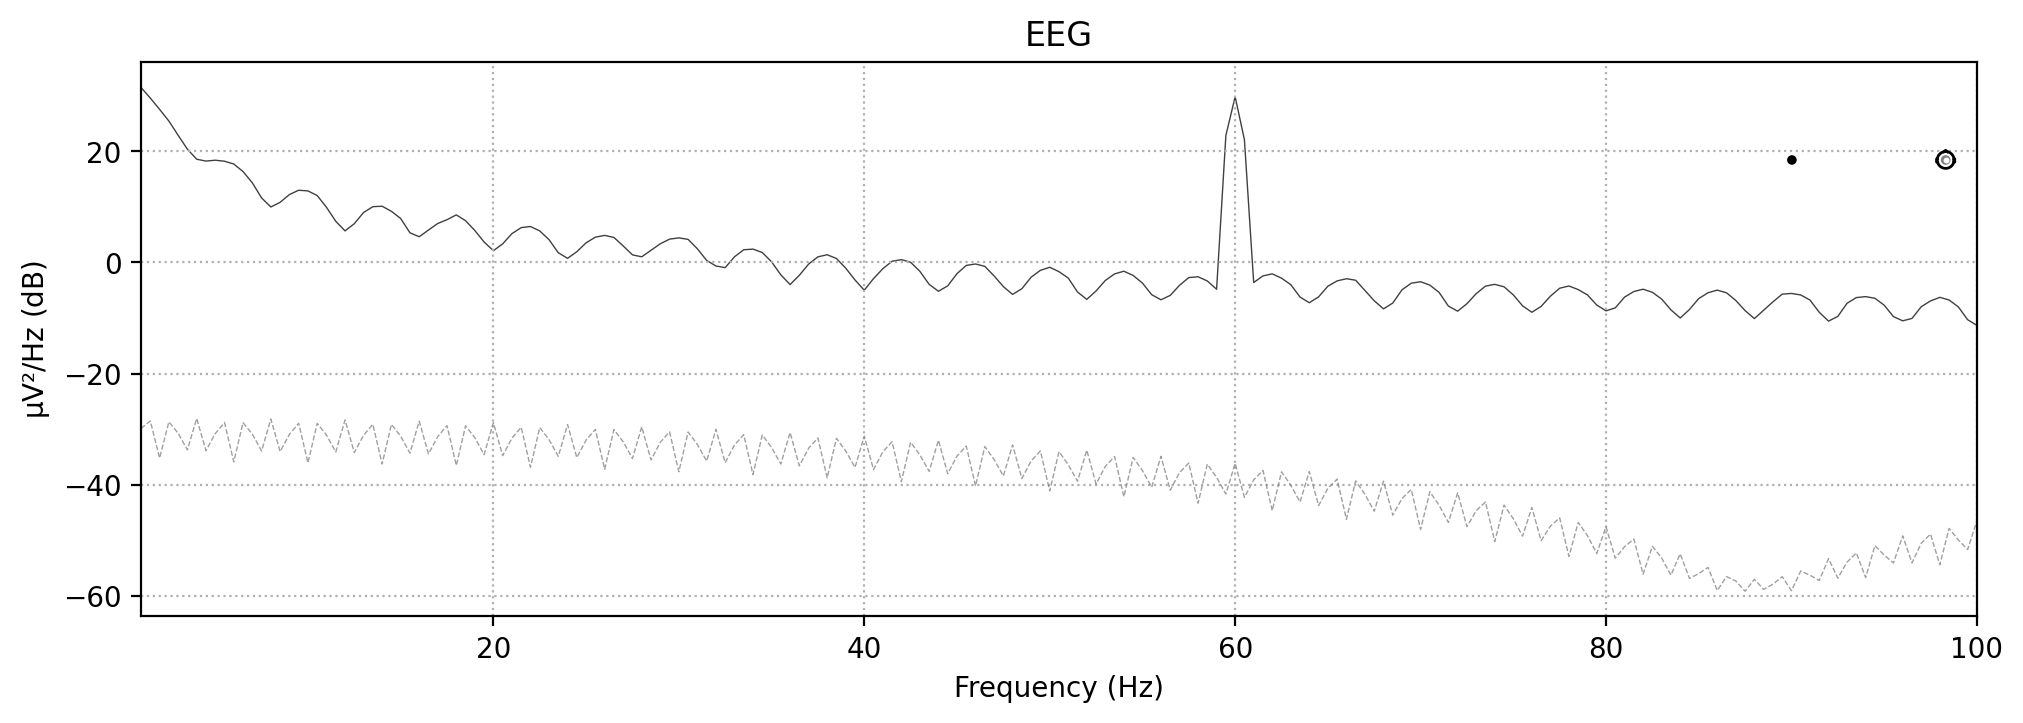

In [4]:
# MMN data analysis
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'

# noNotch
noNotch_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), preload=True)
# Check whether the ch exists
print(noNotch_raw_MMN_fif.info['ch_names'])
print(noNotch_raw_MMN_fif.get_channel_types())
# Rename the channels
noNotch_raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
noNotch_raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})


#Notched
Notched_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_Notched.fif'), preload=True)
# Check whether the ch exists
print(Notched_raw_MMN_fif.info['ch_names'])
print(Notched_raw_MMN_fif.get_channel_types())
# Rename the channels
Notched_raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
Notched_raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})

merged_MMN_LIST = [noNotch_raw_MMN_fif, Notched_raw_MMN_fif]
#merged_MMN_LIST.plot()

merged_MMN = mne.concatenate_raws(merged_MMN_LIST)
merged_MMN.compute_psd(fmin=1, fmax=100).plot()
#merged_MMN.save(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), overwrite=True)

In [10]:
# Compute the psd of two different kinds of gel
orig_MMN_merged_raw_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), preload=True)
orig_MMN_psd = orig_MMN_merged_raw_fif.compute_psd(fmin=1, fmax=100).plot()

new_MMN_merged_raw_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('new_MMN_merged_raw.fif'), preload=True)
new_MMN_psd = new_MMN_merged_raw_fif.compute_psd(fmin=1, fmax=100).plot()

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_MMN_merged_raw.fif...
    Range : 0 ... 817919 =      0.000 ...   798.749 secs
Ready.
Reading 0 ... 817919  =      0.000 ...   798.749 secs...
Effective window size : 2.000 (s)
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/new_MMN_merged_raw.fif...
    Range : 0 ... 825599 =      0.000 ...   806.249 secs
Ready.
Reading 0 ... 825599  =      0.000 ...   806.249 secs...
Effective window size : 2.000 (s)


In [17]:
new_MMN_psd = new_MMN_merged_fif.compute_psd(fmin=1, fmax=70)#.plot()
new_MMN_freqs_ndArray = new_MMN_psd.freqs
new_MMN_power_ndArray = new_MMN_psd.get_data(picks="Fz_1")  # shape: (n_epochs, n_freqs)
new_MMN_avg_power_ndArray = new_MMN_power_ndArray.mean(axis=0)  # mean across epochs

print(new_MMN_psd)
print("=============")
print(new_MMN_freqs_ndArray)
print("=============")
print(new_MMN_power_ndArray)
print("=============")
print(new_MMN_avg_power_ndArray)

alpha_idx = (new_MMN_freqs_ndArray >= 8) & (new_MMN_freqs_ndArray <= 14)
noise_idx = (new_MMN_freqs_ndArray >= 25) & (new_MMN_freqs_ndArray <= 40)  # high-freq muscle-like noise

print(alpha_idx)
print(noise_idx)

Effective window size : 2.000 (s)
<Power Spectrum (from Raw, welch method) | 2 channels × 139 freqs, 1.0-70.0 Hz>
[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5
 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5
 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5 28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5
 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5
 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5 49.  49.5
 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.  56.5
 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5 63.  63.5
 64.  64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70. ]
[[2.40212197e-09 1.67409085e-09 9.79706928e-10 5.70410390e-10
  3.53178265e-10 2.51487122e-10 1.71111676e-10 1.22220794e-10
  9.14861928e-11 7.62090419e-11 6.31439775e-11 4.2936059

In [ ]:
def flag_bad_psd(epochs, channel_name='Fz_1', threshold_alpha_power=2.0, threshold_noise_ratio=2.0):
    """
    Flags PSDs from one channel for poor signal quality.
    
    Parameters:
    - epochs: MNE Epochs object
    - channel_name: str, name of the EEG channel
    - threshold_alpha_power: float, minimum mean alpha power (μV²/Hz)
    - threshold_noise_ratio: float, max acceptable ratio of noise power to alpha
    
    Returns:
    - flags: dict with boolean flags and values
    """
    import numpy as np

    psd = epochs.compute_psd(fmin=1, fmax=40, method='welch')
    freqs = psd.freqs
    power = psd.get_data(picks=channel_name)  # shape: (n_epochs, n_freqs)
    avg_power = power.mean(axis=0)  # mean across epochs

    # Define frequency bands
    alpha_idx = (freqs >= 8) & (freqs <= 12)
    noise_idx = (freqs >= 25) & (freqs <= 40)  # high-freq muscle-like noise

    alpha_power = avg_power[alpha_idx].mean()
    noise_power = avg_power[noise_idx].mean()
    noise_ratio = noise_power / (alpha_power + 1e-6)

In [ ]:

    psd = epochs.compute_psd(fmin=1, fmax=40, method='welch')
    freqs = psd.freqs
    power = psd.get_data(picks=channel_name)  # shape: (n_epochs, n_freqs)
    avg_power = power.mean(axis=0)  # mean across epochs

    # Define frequency bands
    alpha_idx = (freqs >= 8) & (freqs <= 12)
    noise_idx = (freqs >= 25) & (freqs <= 40)  # high-freq muscle-like noise

    alpha_power = avg_power[alpha_idx].mean()
    noise_power = avg_power[noise_idx].mean()
    noise_ratio = noise_power / (alpha_power + 1e-6)

    flags = {
        'low_alpha_power': alpha_power < threshold_alpha_power,
        'high_noise_ratio': noise_ratio > threshold_noise_ratio,
        'alpha_power': alpha_power,
        'noise_power': noise_power,
        'noise_ratio': noise_ratio
    }

    return flags


In [26]:
# Creating the new epochs
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
merged_MMN = mne.io.read_raw_fif(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), preload=True)

# Set the event markers according to the annotations
MMN_eventsArray = mne.events_from_annotations(merged_MMN)[0]
MMN_events = MMN_eventsArray #mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
MMN_event_id = {'standard':1,'deviant_2':2, 'deviant_3': 3}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

epoch_DIR = fif_DIR / 'MMN_epochs'
merged_MMN.filter(0, 70, phase= 'zero-double').resample(500)
#raw_MMN_fif.resample(500)
#raw_MMN_fif.notch_filter(freqs=60)
n_epoch_MMN = mne.Epochs(merged_MMN, MMN_events, MMN_event_id, tmin, tmax, baseline=baseline, preload = True)
print(n_epoch_MMN.info)
#n_epoch_MMN.save(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), overwrite=True)
n_epoch_MMN

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_MMN_merged_raw.fif...
    Range : 0 ... 817919 =      0.000 ...   798.749 secs
Ready.
Reading 0 ... 817919  =      0.000 ...   798.749 secs...
Used Annotations descriptions: ['1', '2', '3', '4']
Filtering raw data in 2 contiguous segments
Setting up low-pass filter at 70 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-12 dB cutoff frequency: 78.75 Hz)
- Filter length: 195 samples (0.190 s)

Not setting metadata
1000 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1000 events and 401 original time poin

Number of events,494
Events,deviant_2: 50deviant_3: 49standard: 395
Time range,-0.100 – 0.700 s
Baseline,-0.100 – 0.000 s


    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


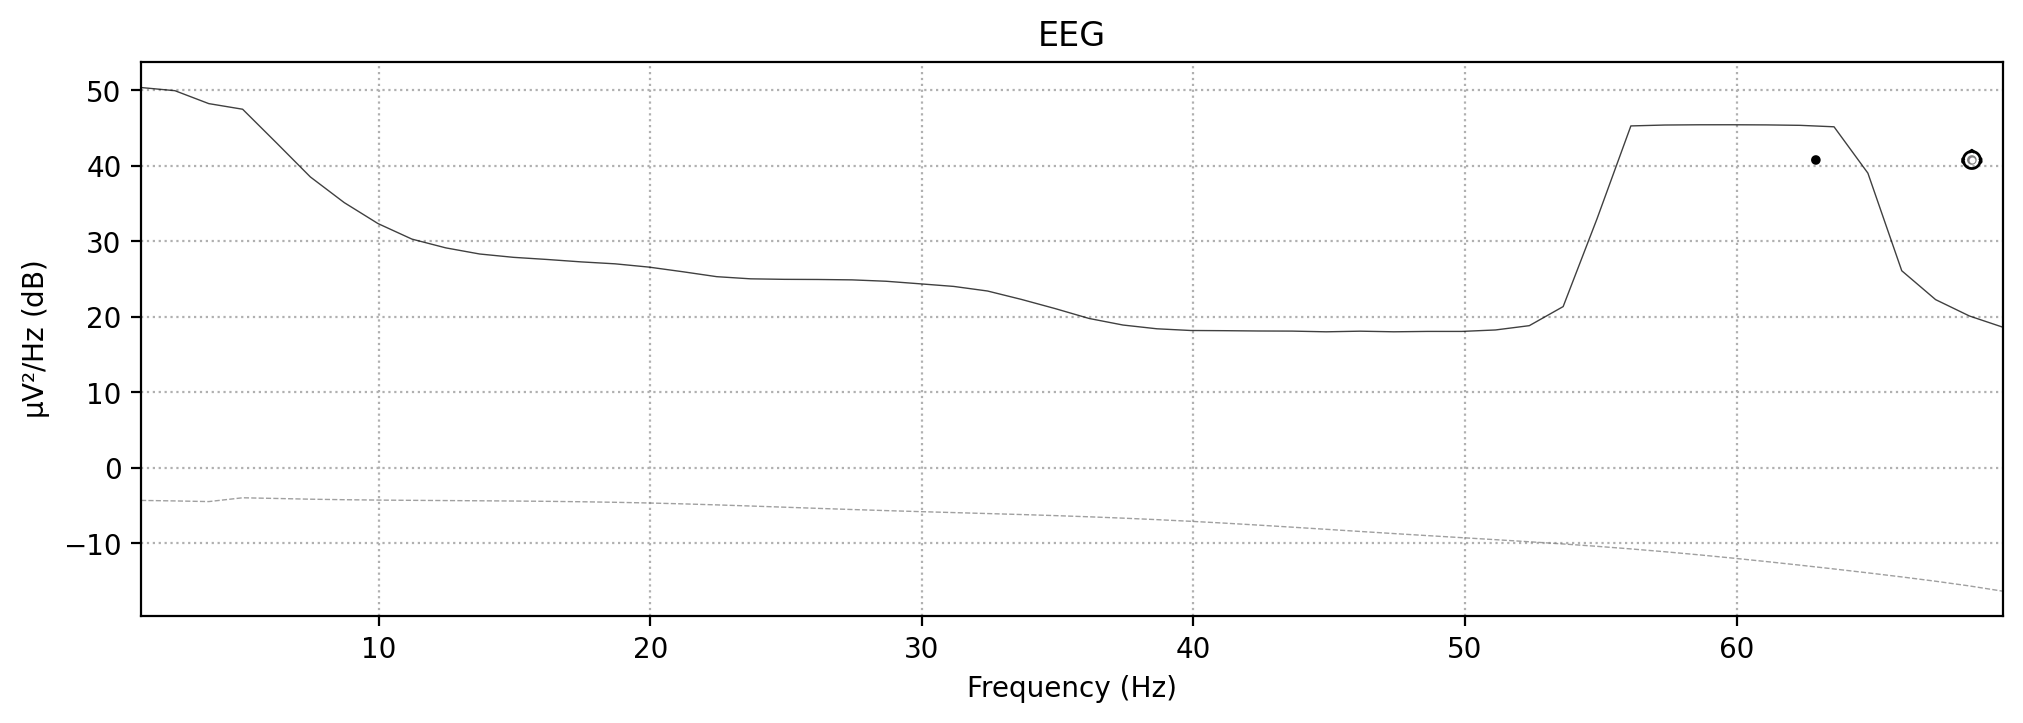

2025-08-23 10:54:52.513 python[38027:21351307] +[CATransaction synchronize] called within transaction


In [27]:
n_epoch_MMN.compute_psd(fmin=1, fmax=70).plot()

In [35]:
# Compute the psd of two different kinds of gel
epoch_DIR = fif_DIR / 'MMN_epochs'
orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_filter70_epochs.fif'), preload=True)
orig_MMN_epoch_psd = orig_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()

new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), preload=True)
new_MMN_epoch_psd = new_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70).plot()

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_filter70_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/630693743.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_filter70_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_filter70_epochs.fif'), preload=True)


Averaging across epochs...
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_filter70_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
499 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/630693743.py:6: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_filter70_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), preload=True)


Averaging across epochs...


In [48]:
def flag_bad_psd(epochs, channel_name='Fz_1', threshold_alpha_power=2.0, threshold_noise_ratio=2.0):
    """
    Flags PSDs from one channel for poor signal quality.
    
    Parameters:
    - epochs: MNE Epochs object
    - channel_name: str, name of the EEG channel
    - threshold_alpha_power: float, minimum mean alpha power (μV²/Hz)
    - threshold_noise_ratio: float, max acceptable ratio of noise power to alpha
    
    Returns:
    - flags: dict with boolean flags and values
    """
    import numpy as np

    psd = epochs.compute_psd(fmin=1, fmax=40, method='welch')
    freqs = psd.freqs
    power = psd.get_data(picks=channel_name)  # shape: (n_epochs, n_freqs)
    avg_power = power.mean(axis=0)  # mean across epochs

    # Define frequency bands
    alpha_idx = (freqs >= 8) & (freqs <= 12)
    noise_idx = (freqs >= 25) & (freqs <= 40)  # high-freq muscle-like noise

    alpha_power = avg_power[0, alpha_idx].mean()
    noise_power = avg_power[0, noise_idx].mean()
    noise_ratio = noise_power / (alpha_power + 1e-6)

    print(alpha_power)
    print(noise_power)
    print(noise_ratio)
    
    flags = {
        'low_alpha_power': alpha_power < threshold_alpha_power,
        'high_noise_ratio': noise_ratio > threshold_noise_ratio,
        'alpha_power': alpha_power,
        'noise_power': noise_power,
        'noise_ratio': noise_ratio
    }

    return flags


In [49]:
orig_psd = flag_bad_psd(orig_MMN_merged_epoch_fif)
print(orig_psd)
new_psd = flag_bad_psd(new_MMN_merged_epoch_fif)
print(new_psd)

Effective window size : 0.802 (s)
1.6983936658867853e-12
3.4341569045428677e-13
3.434151072002439e-07
{'low_alpha_power': True, 'high_noise_ratio': False, 'alpha_power': 1.6983936658867853e-12, 'noise_power': 3.4341569045428677e-13, 'noise_ratio': 3.434151072002439e-07}
Effective window size : 0.802 (s)
6.218085360138811e-12
9.55619029461807e-13
9.556130873780585e-07
{'low_alpha_power': True, 'high_noise_ratio': False, 'alpha_power': 6.218085360138811e-12, 'noise_power': 9.55619029461807e-13, 'noise_ratio': 9.556130873780585e-07}


In [61]:
#orig_psd = flag_bad_psd(orig_MMN_merged_epoch_fif)
epoch_DIR = fif_DIR / 'MMN_epochs'
orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_filter70_epochs.fif'), preload=True)
orig_MMN_epoch_psd = orig_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70) #.plot()
orig_MMN_epoch_freqs = orig_MMN_epoch_psd.freqs
orig_MMN_epoch_power = orig_MMN_epoch_psd.get_data(picks="Fz_1")  # shape: (n_epochs, n_freqs)
orig_MMN_epoch_avg_power = orig_MMN_epoch_power.mean(axis=0)  # mean across epochs

# Define frequency bands
alpha_idx = (orig_MMN_epoch_freqs >= 8) & (orig_MMN_epoch_freqs <= 12)
noise_idx = (orig_MMN_epoch_freqs >= 25) & (orig_MMN_epoch_freqs <= 40)  # high-freq muscle-like noise

#alpha_power = orig_MMN_epoch_avg_power[alpha_idx].mean()
# Correct indexing: channel 0, frequencies masked by alpha_idx
alpha_power = orig_MMN_epoch_avg_power[0, alpha_idx].mean()

noise_power = orig_MMN_epoch_avg_power[0, noise_idx].mean()
noise_ratio = noise_power / (alpha_power + 1e-6)

#print(alpha_power)
#print(noise_power)
#print(noise_ratio)

orig_hz60_idx = np.argmin(np.abs(orig_MMN_epoch_freqs - 60))
orig_power_60hz = orig_MMN_epoch_avg_power[0, orig_hz60_idx]
orig_noise_ratio = orig_power_60hz  / (alpha_power + 1e-6)

print(orig_noise_ratio)
"""
# Assuming `freqs` and `avg_power` from compute_psd
hz60_idx = np.argmin(np.abs(freqs - 60))  # closest frequency bin
power_60hz = avg_power[hz60_idx]
"""
#new_psd = flag_bad_psd(new_MMN_merged_epoch_fif)

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_filter70_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/3823832688.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/orig_MMN_merged_filter70_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('orig_MMN_merged_filter70_epochs.fif'), preload=True)


Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
0.03501083079366626


'\n# Assuming `freqs` and `avg_power` from compute_psd\nhz60_idx = np.argmin(np.abs(freqs - 60))  # closest frequency bin\npower_60hz = avg_power[hz60_idx]\n'

In [60]:
#orig_psd = flag_bad_psd(orig_MMN_merged_epoch_fif)
epoch_DIR = fif_DIR / 'MMN_epochs'
new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), preload=True)
new_MMN_epoch_psd = new_MMN_merged_epoch_fif.compute_psd(fmin=1, fmax=70) #.plot()
new_MMN_epoch_freqs = new_MMN_epoch_psd.freqs
new_MMN_epoch_power = new_MMN_epoch_psd.get_data(picks="Fz_1")  # shape: (n_epochs, n_freqs)
new_MMN_epoch_avg_power = new_MMN_epoch_power.mean(axis=0)  # mean across epochs

# Define frequency bands
new_alpha_idx = (new_MMN_epoch_freqs >= 8) & (new_MMN_epoch_freqs <= 12)
new_noise_idx = (new_MMN_epoch_freqs >= 25) & (new_MMN_epoch_freqs <= 40)  # high-freq muscle-like noise

#alpha_power = orig_MMN_epoch_avg_power[alpha_idx].mean()
# Correct indexing: channel 0, frequencies masked by alpha_idx
new_alpha_power = new_MMN_epoch_avg_power[0, new_alpha_idx].mean()

new_noise_power = new_MMN_epoch_avg_power[0, new_noise_idx].mean()
new_noise_ratio = new_noise_power / (new_alpha_power + 1e-6)

#print(alpha_power)
#print(noise_power)
#print(noise_ratio)

new_hz60_idx = np.argmin(np.abs(new_MMN_epoch_freqs - 60))
new_power_60hz = new_MMN_epoch_avg_power[0, new_hz60_idx]
new_noise_ratio = new_power_60hz  / (new_alpha_power + 1e-6)

print(new_noise_ratio)
"""
# Assuming `freqs` and `avg_power` from compute_psd
hz60_idx = np.argmin(np.abs(freqs - 60))  # closest frequency bin
power_60hz = avg_power[hz60_idx]
"""
#new_psd = flag_bad_psd(new_MMN_merged_epoch_fif)

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_filter70_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
499 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/410642964.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_filter70_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_MMN_merged_epoch_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_filter70_epochs.fif'), preload=True)


0.006256767543514173


'\n# Assuming `freqs` and `avg_power` from compute_psd\nhz60_idx = np.argmin(np.abs(freqs - 60))  # closest frequency bin\npower_60hz = avg_power[hz60_idx]\n'

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=[orig_noise_ratio, new_noise_ratio], palette="pastel")
plt.xticks([0, 1], ['Gel A', 'Gel B'])
plt.ylabel('Power at 60 Hz (μV²/Hz)')
plt.title('60 Hz Line Noise Power by Gel Type')
plt.show()

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/573799708.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=[orig_noise_ratio, new_noise_ratio], palette="pastel")


In [101]:
# Recalculate the merged MMN's evoked
epoch_DIR = fif_DIR / 'MMN_epochs'
epoch_MMN = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)

fig_DIR = root_data_path / 'figs'
MMN_figs_DIR = fig_DIR / 'MMN_figs'

epoch_DIR.mkdir(exist_ok=True)
fig_DIR.mkdir(exist_ok=True)
MMN_figs_DIR.mkdir(exist_ok=True)

# epochs to evoked
evoked_standard = epoch_MMN['standard'].average()
evoked_deviant_2 = epoch_MMN['deviant_2'].average()
evoked_deviant_3 = epoch_MMN['deviant_3'].average()

# Plot mmn differences
tmp = [evoked_standard, evoked_deviant_2, evoked_deviant_3]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mmn_fig = mne.viz.plot_compare_evokeds(tmp, colors = colors) #, axes = 'topo')
#mmn_plot

"""
# Save fig
fig_DIR = root_data_path / 'MMN_figs'
fig_DIR.mkdir(exist_ok=True)
mmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)
"""
#plt.savefig(meg_data_path / Path('H-minus-L_evoked_topomap.png'), overwrite=True). # Check this later

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif ...
    Found the data of interest:
        t =     -99.61 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/192725831.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoch_MMN = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)


"\n# Save fig\nfig_DIR = root_data_path / 'MMN_figs'\nfig_DIR.mkdir(exist_ok=True)\nmmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)\n"

2025-08-22 21:36:05.108 python[16801:20845248] +[CATransaction synchronize] called within transaction


In [107]:
print(n_epoch_MMN.drop_log())
n_epoch_MMN.plot_drop_log()

TypeError: 'tuple' object is not callable

In [104]:
# Use Amplitude-Based Heuristics

new_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_epochs.fif'), preload=True)
orig_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('original_MMN_merged_epochs.fif'), preload=True)
new_data = new_MMN_merged_fif.get_data(picks='Fz_1')[0]  # assuming Fz_1 is your only channel
orig_data = orig_MMN_merged_fif.get_data(picks='Fz_1')[0]  # assuming Fz_1 is your only channel

new_peak_to_peak = new_data.max() - new_data.min()
orig_peak_to_peak = orig_data.max() - orig_data.min()

print(f"New Peak-to-peak amplitude: {new_peak_to_peak*1e6:.2f} µV")
print(f"Orignal Peak-to-peak amplitude: {orig_peak_to_peak*1e6:.2f} µV")

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/297731866.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_epochs.fif'), preload=True)


Not setting metadata
499 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/original_MMN_merged_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
470 matching events found
No baseline correction applied
0 projection items activated
New Peak-to-peak amplitude: 39.34 µV
Orignal Peak-to-peak amplitude: 39.47 µV


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/297731866.py:4: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/original_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('original_MMN_merged_epochs.fif'), preload=True)


'\n# Compute Variance or SNR as Proxy for Conductivity\nepochs = mne.Epochs(raw, events, event_id, tmin=-0.1, tmax=0.8, preload=True)\ndata = epochs.get_data(picks=\'Fz_1\')\nvariances = data.var(axis=2).flatten()\nprint(f"Variance across trials: {variances.mean():.2e} µV²")\n'

In [24]:
# get to know the reason of bad epoch drop
print(epoch_LDT.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 117',), (), ())


## Close Eye & Open Eyes. (Brainwaves)

In [64]:
# Datapath setting
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)
# Save the cnt into .fif for a easier further analysis
fif_DIR = root_data_path / 'rawfif_all'
fiveTask_fif_DIR = fif_DIR / '5Tasks'
epoch_DIR = fif_DIR / 'MMN_epochs'
fig_DIR = root_data_path / 'figs'
fiveTask_figs_DIR = fig_DIR / '5tasks_figs'

fif_DIR.mkdir(exist_ok=True)
epoch_DIR.mkdir(exist_ok=True)
fig_DIR.mkdir(exist_ok=True)
fiveTask_figs_DIR.mkdir(exist_ok=True)

/Users/neuroling/Downloads/20250610_EEG-Demo


In [71]:
# Close eyes and open eyes

# noNotch
noNotch_raw_fif = mne.io.read_raw_fif(fiveTask_fif_DIR/ Path('eyeClose_2min_original_noNotch.fif'), preload=True)
# Check whether the ch exists
print(noNotch_raw_fif.info['ch_names'])
print(noNotch_raw_fif.get_channel_types())
# Rename the channels
noNotch_raw_fif.rename_channels({'Fz_1': 'Fz_1'})
noNotch_raw_fif.set_channel_types({'Fz_1': 'eeg'})


#Notched
Notched_raw_fif = mne.io.read_raw_fif(fiveTask_fif_DIR / Path('eyeClose_2min_original_Notched.fif'), preload=True)
# Check whether the ch exists
print(Notched_raw_fif.info['ch_names'])
print(Notched_raw_fif.get_channel_types())
# Rename the channels
Notched_raw_fif.rename_channels({'Fz_1': 'Fz_1'})
Notched_raw_fif.set_channel_types({'Fz_1': 'eeg'})

merged_LIST = [noNotch_raw_fif, Notched_raw_fif]
#merged_MMN_LIST.plot()

merged_raw = mne.concatenate_raws(merged_LIST)
merged_raw.compute_psd(fmin=1, fmax=100).plot()
merged_raw.save(uncut_fif_DIR / Path('orig_eyeClose_2min_merged_raw.fif'), overwrite=True)

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5Tasks/eyeClose_2min_original_noNotch.fif...
    Range : 144455 ... 280721 =    141.069 ...   274.142 secs
Ready.
Reading 0 ... 136266  =      0.000 ...   133.072 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5Tasks/eyeClose_2min_original_Notched.fif...
    Range : 144455 ... 280721 =    141.069 ...   274.142 secs
Ready.
Reading 0 ... 136266  =      0.000 ...   133.072 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Effective window size : 2.000 (s)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/825868827.py:4: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5Tasks/eyeClose_2min_original_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  noNotch_raw_fif = mne.io.read_raw_fif(fiveTask_fif_DIR/ Path('eyeClose_2min_original_noNotch.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/825868827.py:14: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5Tasks/eyeClose_2min_original_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  Notch

Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_eyeClose_2min_merged_raw.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_eyeClose_2min_merged_raw.fif
[done]


2025-08-23 15:52:51.402 python[38027:21351307] +[CATransaction synchronize] called within transaction


In [109]:
# Creating the new epochs
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
fiveTask_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('orig_eyeClose_2min_merged_raw.fif'), preload=True)
fiveTask_merged_fif.plot()

# Set the event markers according to the annotations
fiveTask_eventsArray = mne.events_from_annotations(fiveTask_merged_fif)[0]
print(fiveTask_eventsArray)

fiveTask_events = fiveTask_eventsArray #mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
fiveTask_event_id = {'start':2} #, 'end':55} # eye close #,'deviant_2':2, 'deviant_3': 3}  
#fiveTask_event_id = {'start':1}#, 'end':55} # eye open #,'deviant_2':2, 'deviant_3': 3}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 2 # for 2 seconds          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

fivetasks_epoch_DIR = fif_DIR / '5tasks_epochs'
fivetasks_epoch_DIR.mkdir(exist_ok=True)
#fiveTask_merged_fif.filter(0, 70, phase= 'zero-double').resample(500)
#raw_MMN_fif.resample(500)
#raw_MMN_fif.notch_filter(freqs=60)
n_epoch_5tasks = mne.Epochs(fiveTask_merged_fif, fiveTask_events, fiveTask_event_id, tmin, tmax, baseline=baseline, preload = True)
print(n_epoch_5tasks.info)
n_epoch_5tasks.save(fivetasks_epoch_DIR / Path('orig_eyeClose_2min_nofilter_epochs.fif'), overwrite=True)
n_epoch_5tasks

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_eyeClose_2min_merged_raw.fif...
    Range : 144455 ... 416988 =    141.069 ...   407.215 secs
Ready.
Reading 0 ... 272533  =      0.000 ...   266.146 secs...
Using pyopengl with version 3.1.1a1
Used Annotations descriptions: ['2', '21', '55']
[[144455      0      1]
 [207433      0      2]
 [280721      0      3]
 [280722      0      1]
 [343700      0      2]
 [416988      0      3]]
Not setting metadata
2 matching events found
Setting baseline interval to [-0.099609375, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 2151 original time points ...
0 bad epochs dropped
<Info | 12 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 2 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 05:48:18 UTC
 m

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/2302551460.py:30: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/orig_eyeClose_2min_nofilter_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  n_epoch_5tasks.save(fivetasks_epoch_DIR / Path('orig_eyeClose_2min_nofilter_epochs.fif'), overwrite=True)


Number of events,2
Events,start: 2
Time range,-0.100 – 2.000 s
Baseline,-0.100 – 0.000 s


Channels marked as bad:
['Trigger']


In [108]:
n_eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('new_eyeOpen_2min_nofilter_epochs.fif'), preload=True)
n_eyeO_epoch

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/new_eyeOpen_2min_nofilter_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/1099971645.py:1: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/new_eyeOpen_2min_nofilter_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  n_eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('new_eyeOpen_2min_nofilter_epochs.fif'), preload=True)


Number of events,494
Events,deviant_2: 50deviant_3: 49standard: 395
Time range,-0.100 – 0.700 s
Baseline,-0.100 – 0.000 s


In [102]:
import numpy as np
import matplotlib.pyplot as plt


## Import epochs
# Original gel
#eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('orig_eyeOpen_2min_nofilter_epochs.fif'), preload=True)
#eyeC_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('orig_eyeClose_2min_nofilter_epochs.fif'), preload=True)
# New gel
eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('new_eyeOpen_2min_nofilter_epochs.fif'), preload=True)
eyeC_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('new_eyeClose_2min_nofilter_epochs.fif'), preload=True)


# Step 1: Compute PSD for each condition
psd_ce = eyeO_epoch.compute_psd(fmin=0.5, fmax=45) #, method='welch')
psd_oe = eyeC_epoch.compute_psd(fmin=0.5, fmax=45) #, method='welch')

# Step 2: Extract frequency and power arrays
freqs = psd_ce.freqs
power_ce = psd_ce.get_data(picks='Fz_1')  # shape (n_epochs, n_freqs)
power_oe = psd_oe.get_data(picks='Fz_1')

# Step 3: Define frequency band indices
band_ranges = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (13, 30),
    'Gamma': (30, 45),
}

# Step 4: Compute mean power per band
band_power_ce = []
band_power_oe = []

# Squeeze out the single channel dimension
power_ce = np.squeeze(power_ce)  # shape: (n_epochs, n_freqs)
power_oe = np.squeeze(power_oe)


for band, (fmin, fmax) in band_ranges.items():
    idx = (freqs >= fmin) & (freqs < fmax)
    band_ce = power_ce[:, idx].mean()
    band_oe = power_oe[:, idx].mean()
    band_power_ce.append(band_ce)
    band_power_oe.append(band_oe)

print("power_ce shape:", power_ce.shape)  # should be (n_epochs, n_freqs)
print("freqs shape:", freqs.shape)        # should be (n_freqs,)

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/new_eyeOpen_2min_nofilter_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/new_eyeClose_2min_nofilter_epochs.fif ...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/3315440683.py:10: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/new_eyeOpen_2min_nofilter_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  eyeO_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('new_eyeOpen_2min_nofilter_epochs.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_38027/3315440683.py:11: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/5tasks_epochs/new_eyeClose_2min_nofilter_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  eyeC_epoch = mne.read_epochs(fivetasks_epoch_DIR / Path('new_eyeClose_2min_nofilter_epochs.fif'), preload=True)


    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
power_ce shape: (494, 36)
freqs shape: (36,)
